In [3]:
from importlib import reload
import numpy as np
import mido
import os
from scipy.sparse import csc_matrix, csr_matrix
import pickle
import pretty_midi
import sys
import copy
from collections import namedtuple
import timeit
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
# import modules, including a reload statement so that they can be reimported after a change to the methods 
import src.midi_utils as midi_utils
reload(midi_utils)

import src.data as data
reload(data)

import src.models as models
reload(models)

import src.ml_classes as ml_classes
reload(ml_classes)

<module 'src.ml_classes' from '/storage/781-piano-autoencoder/src/ml_classes.py'>

# Data Exploration
This notebook contains the code needed to make the plots found in the project report, and a few other plots besides. This includes comparisons of training and validation loss for different model configurations.

## Offsets
As it turns out, I play quite ahead of the beat...

In [14]:
# load data (non sparse)
model_datas, _ = data.folder2examples('training_data/midi_val', sparse=False, use_base_key=True, beats_per_ex=int(32 / 4))

100%|██████████| 8/8 [00:03<00:00,  2.22it/s]

00h 45m 12s of data
created model data H :    (32, 88) data shape,     416 training examples
created model data O :    (32, 88) data shape,     416 training examples
created model data V :    (32, 88) data shape,     416 training examples
created model data R :    (32, 88) data shape,     416 training examples
created model data S :    (32, 2) data shape,     416 training examples
created model data key :    (12,) data shape,     416 training examples
created model data tempo :    (1,) data shape,     416 training examples
created model data V_mean :    (1,) data shape,     416 training examples


In [13]:
model_datas_8, _ = data.folder2examples('training_data/midi_val_8', sparse=False, use_base_key=True, beats_per_ex=int(32 / 4))

100%|██████████| 12/12 [00:03<00:00,  3.12it/s]

00h 39m 07s of data
created model data H :    (32, 88) data shape,     504 training examples
created model data O :    (32, 88) data shape,     504 training examples
created model data V :    (32, 88) data shape,     504 training examples
created model data R :    (32, 88) data shape,     504 training examples
created model data S :    (32, 2) data shape,     504 training examples
created model data key :    (12,) data shape,     504 training examples
created model data tempo :    (1,) data shape,     504 training examples
created model data V_mean :    (1,) data shape,     504 training examples


Text(0, 0.5, 'Frequency')

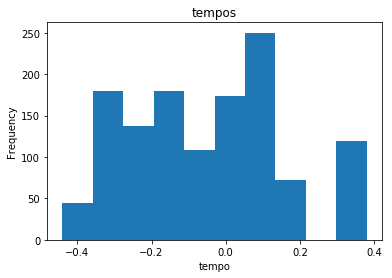

In [51]:
# plot frequency of different tempo examples
plt.hist(model_datas['tempo'].data)
plt.title('tempos')
plt.xlabel('tempo')
plt.ylabel('Frequency')

In [53]:
# get the offsets
slow_examples = np.where(model_datas['tempo'].data < -0.1)[0]
fast_examples = np.where(model_datas['tempo'].data >= -0.1)[0]

offsets = model_datas['O'].data[np.where(model_datas['O'].data != 0)]
offsets_slow = model_datas['O'].data[slow_examples][np.where(model_datas['O'].data[slow_examples] != 0)]
offsets_fast = model_datas['O'].data[fast_examples][np.where(model_datas['O'].data[fast_examples] != 0)]

# get the mean offset
print('Average offset:', np.mean(offsets))
print('Average offset (slow):', np.mean(offsets_slow))
print('Average offset (fast):', np.mean(offsets_fast))
# np.mean(model_datas['O'].data[np.where(model_datas['O'].data != 0)])

Average offset: -0.2159549405151239
Average offset (slow): -0.2122750100740251
Average offset (fast): -0.21921260114292063


### Plot distribution of Velocities

0.007874015748031496
0.16189374286630712
0.15373341375095834


(array([ 184.,  138.,  342.,  784., 1124., 1092., 1338., 1129.,  914.,
         871.,  757.,  487.,  659.,  311.,  324.,  352.,  200.,  186.,
         183.,   63.,   77.,   50.,   28.,   27.,    7.]),
 array([0.00787402, 0.04440945, 0.08094488, 0.11748031, 0.15401575,
        0.19055118, 0.22708661, 0.26362205, 0.30015748, 0.33669291,
        0.37322835, 0.40976378, 0.44629921, 0.48283465, 0.51937008,
        0.55590551, 0.59244094, 0.62897638, 0.66551181, 0.70204724,
        0.73858268, 0.77511811, 0.81165354, 0.84818898, 0.88472441,
        0.92125984]),
 <a list of 25 Patch objects>)

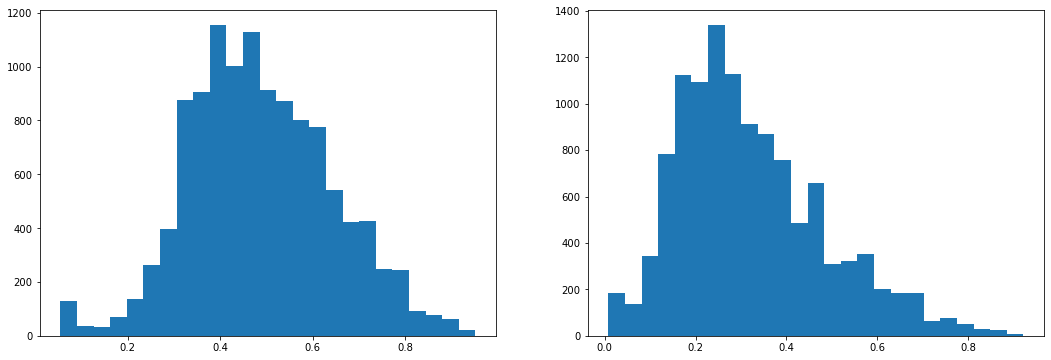

In [43]:
old_v = model_datas['V'].data[np.where(model_datas['V'].data != 0)].flatten()
new_v = model_datas_8['V'].data[np.where(model_datas_8['V'].data != 0)].flatten()
print(np.min(new_v))
# plot velocities

def normalize_velocity(velocity, inverse=False):
    if not inverse:
        return velocity ** 0.6
        return velocity ** 0.6 - ((velocity - 0.5) - 0.5) * (velocity - 0.5)

print(np.std(old_v))
print(np.std(normalize_velocity(old_v)))



plt.figure(figsize=(18,6))
plt.subplot(121)
plt.hist(normalize_velocity(old_v), bins=25)
plt.subplot(122)
plt.hist(old_v, bins=25)

In [12]:
model_datas

({'H': <src.ml_classes.ModelData at 0x7f6df958f520>,
  'O': <src.ml_classes.ModelData at 0x7f6dfa276c70>,
  'V': <src.ml_classes.ModelData at 0x7f6df958f550>,
  'R': <src.ml_classes.ModelData at 0x7f6df958f7f0>,
  'S': <src.ml_classes.ModelData at 0x7f6df958f5b0>,
  'tempo': <src.ml_classes.ModelData at 0x7f6df958f1c0>,
  'key': <src.ml_classes.ModelData at 0x7f6df958f880>,
  'V_mean': <src.ml_classes.ModelData at 0x7f6df958f6d0>},
 2712.654270699751)

### Plotting note offsets
Ideally the distribution would be centered at zero - it's not!

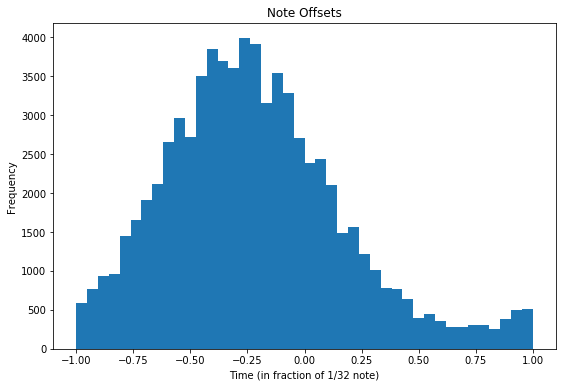

In [58]:
plt.figure(figsize=(9,6))
# plt.yscale('log')
plt.hist(offsets, bins=42)
plt.title('Note Offsets')
plt.xlabel('Time (in fraction of 1/32 note)')
plt.ylabel('Frequency')
plt.savefig('evidence')

### Plotting note offsets by tempo
It is much worse for faster tempos

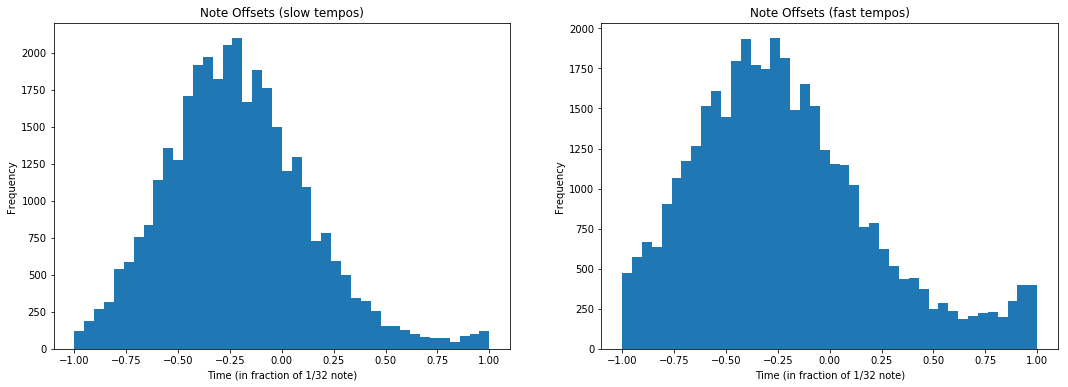

In [49]:
slow_examples = np.where(model_datas['tempo'].data < -0.1)[0]
fast_examples = np.where(model_datas['tempo'].data >= -0.1)[0]
offsets_slow = model_datas['O'].data[slow_examples][np.where(model_datas['O'].data[slow_examples] != 0)]
offsets_fast = model_datas['O'].data[fast_examples][np.where(model_datas['O'].data[fast_examples] != 0)]

plt.figure(figsize=(18,6))
plt.subplot(121)

# plt.xlim((0,36))
plt.hist(offsets_slow, bins=42)
# plt.yscale('log')
plt.title('Note Offsets (slow tempos)')
plt.xlabel('Time (in fraction of 1/32 note)')
plt.ylabel('Frequency')

plt.subplot(122)
# plt.xlim((0,36))
plt.hist(offsets_fast, bins=42)
# plt.yscale('log')
plt.title('Note Offsets (fast tempos)')
plt.xlabel('Time (in fraction of 1/32 note)')
plt.ylabel('Frequency')
plt.savefig('fastVSslow')

## Returning to midi format
This code generates some midi files for random training examples.  
Assumes all information is present, including pedal etc.

In [ ]:
# given complete set of model datas, go back to midi format
for i in range(5):
    pm =data.examples2pm(model_datas)
    pm.write(f'test{i}.mid')

## Pitch/Beat/Velocity Relationships
### Velocity and Pitch Class

In [61]:
# load data that is all in the same key (non sparse)
with open('training_data/model_datas_non_sparse_base_key_03-04', 'rb') as f:
    model_datas = pickle.load(f)

In [ ]:
# velocity by pitch class
note_indices = np.where(model_datas['H'].data != 0)
v_by_pitch = [[] for _ in range(12)]
for idx in zip(*note_indices):
    v_by_pitch[idx[-1] % 12].append(model_datas['V'].data[idx])

<Figure size 1296x432 with 0 Axes>

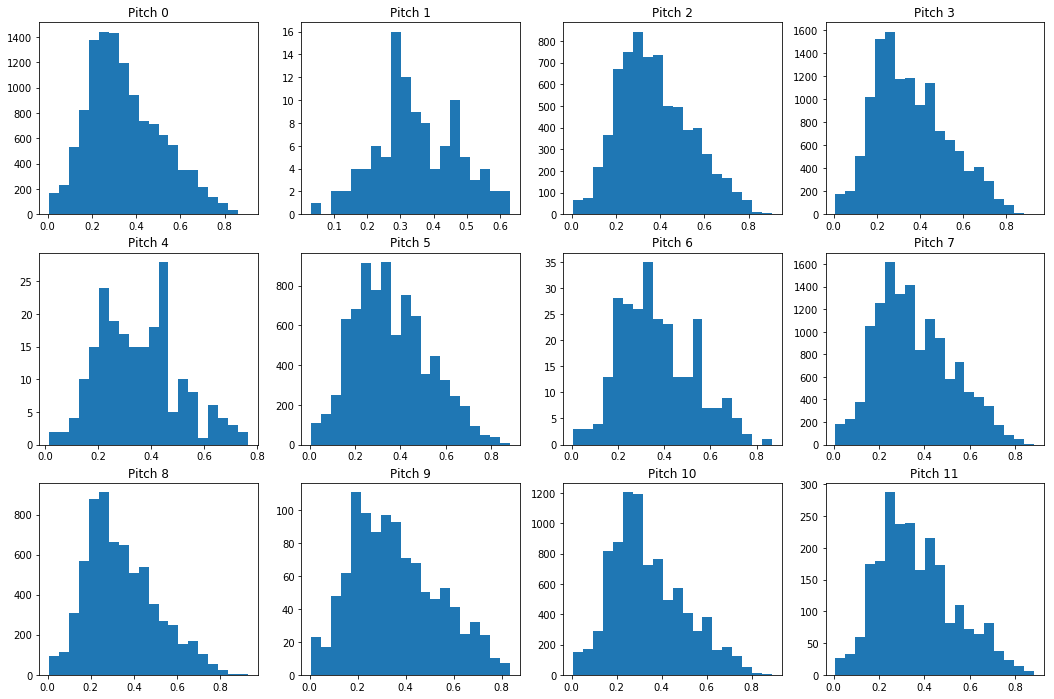

In [91]:
# plot velocities by pitch class
fig, ax = plt.subplots(nrows=3,ncols=4, figsize=(18,12))
ax = [a for sublist in ax for a in sublist]
for i in range(len(v_by_pitch)):
    ax[i].hist(v_by_pitch[i], bins=20)
    ax[i].set_title(f'Pitch {i}')

### Velocities and Beats

In [99]:
# velocity by beat
note_indices = np.where(model_datas['H'].data != 0)

v_by_beat_sub_beats = [[] for _ in range(4)]
for idx in zip(*note_indices):
    v_by_beat_sub_beats[idx[-2] % 4].append(model_datas['V'].data[idx])
    
v_by_bar_sub_beats = [[] for _ in range(16)]
for idx in zip(*note_indices):
    v_by_bar_sub_beats[idx[-2] % 16].append(model_datas['V'].data[idx])

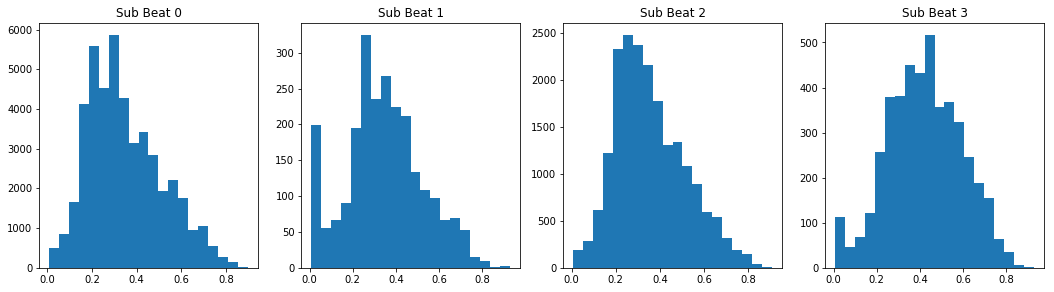

In [102]:
# plot velocities by beat sub beats
fig, ax = plt.subplots(nrows=1,ncols=4, figsize=(18,4.5))
for i in range(len(v_by_beat_sub_beats)):
    ax[i].hist(v_by_beat_sub_beats[i], bins=20)
    ax[i].set_title(f'Sub Beat {i+1}')

The mode of sub beat 4 is much higher than any others, even though it is the most 'minor' beat.

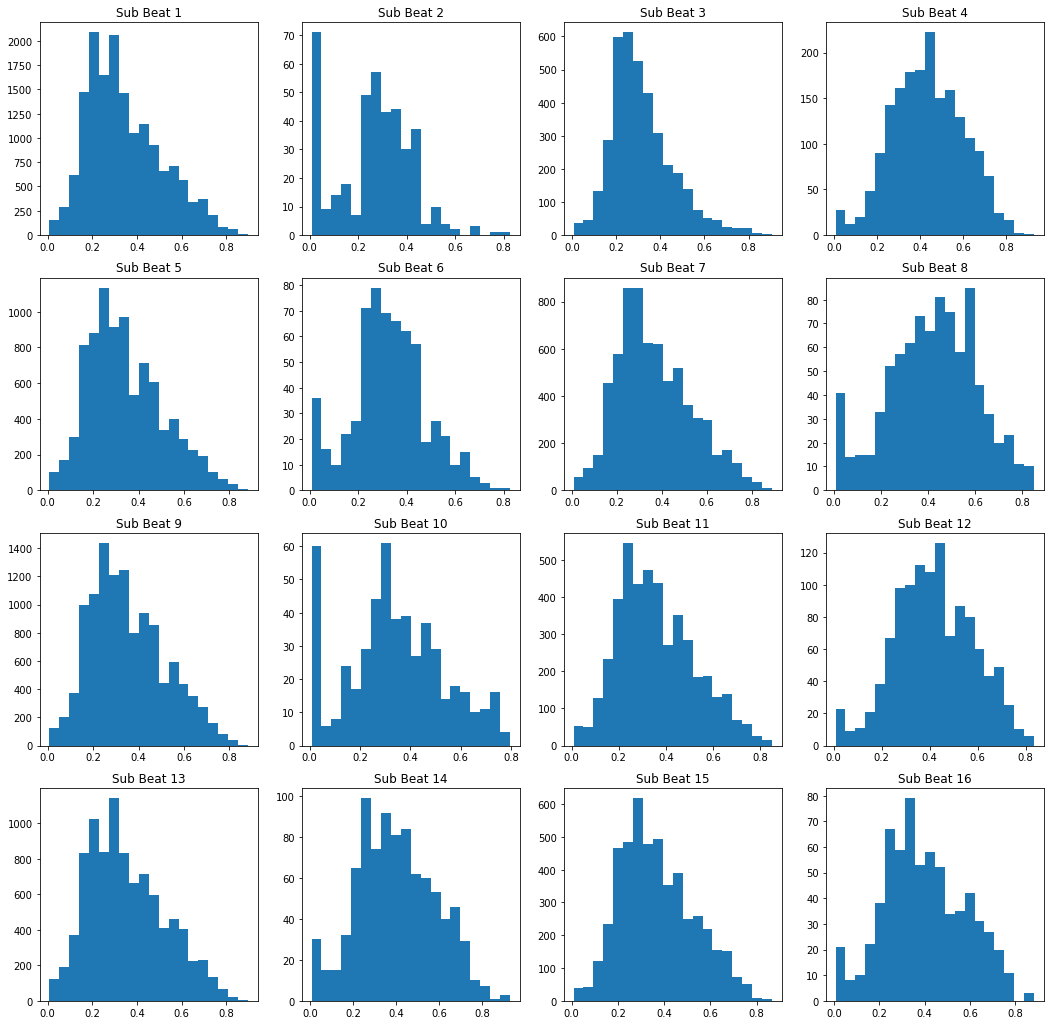

In [104]:
# plot velocities by bar sub beats
fig, ax = plt.subplots(nrows=4,ncols=4, figsize=(18,18))
ax = [a for sublist in ax for a in sublist]
for i in range(len(v_by_bar_sub_beats)):
    ax[i].hist(v_by_bar_sub_beats[i], bins=20)
    ax[i].set_title(f'Sub Beat {i+1}')

Notice the differing scales on y axes. There is precisely the kind of musical hierarchy we would expect:  
- Sub beat 1, the down beat, has by far the most notes, followed by sub beat 3.  
- Within beats (each row), the first sub beat has the most hits, followed by the third.  

### Pitch Class and Beats

In [ ]:
# velocity by pitch class
note_indices = np.where(model_datas['H'].data != 0)
pitch_by_beat = [[] for _ in range()]
for idx in zip(*note_indices):
    v_by_pitch[idx[-1] % 12].append(model_datas['V'].data[idx])

### Generate plots of offset distributions for each file

In [ ]:
files = [file for file in os.scandir('training_data_v0/midi_files')]
print(type(files[i]))
for i, file in enumerate(files):
    if i % 5 == 0:
        print(f'file {i} of {len(files)}')
    pm = pretty_midi.PrettyMIDI(file.path)
    key = data.filepath2key(file.path)
    examples = midi_utils.pm2example(pm, key=key, sparse=False)
    offsets = examples['O'][np.where(examples['H'] != 0)]
    plt.figure(figsize=(9,6))
    # plt.yscale('log')
    plt.hist(offsets, bins=42)
    plt.title('Note Offsets')
    plt.xlabel('Time (in fraction of 1/32 note)')
    plt.ylabel('Frequency')
    plt.savefig(f'training_data/offsets/plt{i}')

Try centering these plots, by centering the midi files

In [ ]:
sub_beats=4
files = [file for file in os.scandir('training_data_v0/midi_files')]
print(type(files[i]))
for i, file in enumerate(files):
    if i % 5 == 0:
        prin t(f'file {i} of {len(files)}')
    pm = pretty_midi.PrettyMIDI(file.path)
    
    beat_length = 60 / pm.get_tempo_changes()[-1][0]
    sub_beat_length = beat_length / sub_beats
    max_offset = sub_beat_length / 2
    offsets = []
    # get all offsets (distance to nearest subbeat)
    for note in pm.instruments[0].notes:
        # time since last sub beat
        offset = note.start % sub_beat_length
        # are we closer to the last sub beat, or next sub beat? 
        if offset > max_offset:
            offset = offset - sub_beat_length
        offsets.append(offset)

    mean_offset = np.mean(offsets)

    for note in pm.instruments[0].notes:
        note.start -= mean_offset
        note.end -= mean_offset
    for cc in pm.instruments[0].control_changes:
        cc.time -= mean_offset
    
    key = data.filepath2key(file.path)
    examples = midi_utils.pm2example(pm, key=key, sparse=False)
    offsets = examples['O'][np.where(examples['H'] != 0)]
    plt.figure(figsize=(9,6))
    # plt.yscale('log')
    plt.hist(offsets, bins=42)
    plt.title('Note Offsets')
    plt.xlabel('Time (in fraction of 1/32 note)')
    plt.ylabel('Frequency')
    plt.savefig(f'training_data/offsets/plt{i}centered')

### Filtering Notes

In [61]:
# total notes
print(len(np.where(model_datas['H'].data != 0)[0]))
# how many notes are missed out by filtering out (almost) inaudible notes?
print(len(np.where(model_datas['V'].data != 0)[0]) - len(np.where(model_datas['V'].data > 0.02)[0]))
# how many offsets are exactly zero?
print(len(np.where(model_datas['H'].data != 0)[0]) - len(np.where(model_datas['O'].data != 0)[0]))

9693
110
20


### Plotting Notes

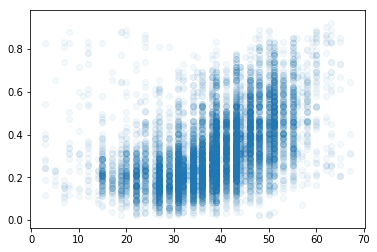

In [56]:
note_indices = np.where(model_datas['V'].data > 0.02)


pitches = note_indices[-1]
velocities = model_datas['V'].data[note_indices]
offsets = model_datas['O'].data[note_indices]
tempi = model_datas['tempo'].data[note_indices[:-2]]

# pitches by velocity - generally louder for higher notes. But notice the trend in the lower region, between10 and twenty - these are frequently played louder .
plt.scatter(pitches, velocities, alpha=0.05)
plt.scatter(pitches, velocities, alpha=0.05)
# plt.scatter(pitches, offsets, alpha=0.1)
# plt.scatter([abs(o) for o in offsets], tempi, alpha=0.1)